In [22]:
import os
import glob
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
# Import EfficientNetB3
from tensorflow.keras.applications import EfficientNetB3
# Import its respective preprocess_input function (EfficientNet models do not have a dedicated preprocess_input)
# EfficientNet models expect pixel values in the range [0, 255] or normalized to [0, 1]
# We will handle normalization within the process_img function.
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

In [25]:
# === CONFIG ===
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

BASE_PATH = r"C:\Users\ADITYA DAS\Desktop\Machine Learning\CP_DATASET"
CLASSES = ["BLIGHT", "BLAST", "BROWNSPOT", "HEALTHY"]
# EfficientNetB3 expects input shape (300, 300)
IMG_SIZE = (300, 300) # For EfficientNetB3
BATCH_SIZE = 32
EPOCHS = 2
LEARNING_RATE = 1e-5

In [26]:
# === Load filepaths & labels ===
all_filepaths, all_labels = [], []
for idx, class_name in enumerate(CLASSES):
    aug_path = os.path.join(BASE_PATH, class_name, "augmented")
    files = glob.glob(os.path.join(aug_path, "*.jpg")) + \
            glob.glob(os.path.join(aug_path, "*.jpeg")) + \
            glob.glob(os.path.join(aug_path, "*.png"))
    all_filepaths.extend(files)
    all_labels.extend([idx] * len(files))

print(f"✅ Total images found: {len(all_filepaths)}")

✅ Total images found: 24004


In [27]:
# === tf.data.Dataset ===
filepaths_ds = tf.data.Dataset.from_tensor_slices(all_filepaths)
labels_ds = tf.data.Dataset.from_tensor_slices(all_labels)
ds = tf.data.Dataset.zip((filepaths_ds, labels_ds)).shuffle(len(all_filepaths), seed=SEED)

train_size = int(0.8 * len(all_filepaths))
train_ds = ds.take(train_size)
val_ds = ds.skip(train_size)

print(f"✅ Train samples: {train_size} | Val samples: {len(all_filepaths) - train_size}")

✅ Train samples: 19203 | Val samples: 4801


In [28]:
# === Color Jitter ===
def color_jitter(image):
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.05)
    return tf.clip_by_value(image, 0.0, 255.0)

# === GridMask ===
def grid_mask(image, d_min=50, d_max=100, ratio=0.5):
    h, w, _ = image.shape
    d = tf.random.uniform([], d_min, d_max, dtype=tf.int32)
    l = tf.cast(tf.cast(d, tf.float32) * ratio, tf.int32)

    mask = tf.ones([h, w], dtype=tf.float32)

    for i in tf.range(0, h, d):
        for j in tf.range(0, w, d):
            y1 = i
            y2 = tf.minimum(i + l, h)
            x1 = j
            x2 = tf.minimum(j + l, w)

            y_range = tf.range(y1, y2)
            x_range = tf.range(x1, x2)
            yy, xx = tf.meshgrid(y_range, x_range, indexing='ij')
            indices = tf.stack([yy, xx], axis=-1)
            indices = tf.reshape(indices, [-1, 2])

            mask = tf.tensor_scatter_nd_update(
                mask,
                indices,
                tf.zeros([(y2 - y1) * (x2 - x1)], dtype=tf.float32)
            )

    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.tile(mask, [1, 1, 3])
    return image * mask

# === Image Processor ===
def process_img(filepath, label):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)

    # Apply data augmentation only for training
    # This function will be mapped to both train_ds and val_ds initially,
    # but CutMix is only applied to train_ds later.
    # Color jitter and GridMask are applied here for both, which is consistent
    # with the original notebook's implicit application before batching.
    img = color_jitter(img)
    img = grid_mask(img)

    # EfficientNet models expect input in [0, 255] or normalized to [0, 1].
    # Since we are using pre-trained weights from 'imagenet', it's best to normalize
    # to [0, 1] by dividing by 255.0.
    img = img / 255.0

    label = tf.one_hot(label, depth=len(CLASSES))
    return img, label

# === CutMix ===
def cutmix(images, labels, alpha=1.0):
    batch_size = tf.shape(images)[0]
    img_h = tf.shape(images)[1]
    img_w = tf.shape(images)[2]

    lam = tfp.distributions.Beta(alpha, alpha).sample([batch_size])

    rand_idx = tf.random.shuffle(tf.range(batch_size))
    images2 = tf.gather(images, rand_idx)
    labels2 = tf.gather(labels, rand_idx)

    cut_rat = tf.math.sqrt(1. - lam)
    cut_w = tf.cast(img_w, tf.float32) * cut_rat
    cut_h = tf.cast(img_h, tf.float32) * cut_rat

    cx = tf.random.uniform([batch_size], 0, tf.cast(img_w, tf.float32))
    cy = tf.random.uniform([batch_size], 0, tf.cast(img_h, tf.float32))

    x1 = tf.cast(cx - cut_w / 2, tf.int32)
    y1 = tf.cast(cy - cut_h / 2, tf.int32)
    x2 = tf.cast(cx + cut_w / 2, tf.int32)
    y2 = tf.cast(cy + cut_h / 2, tf.int32)

    x1 = tf.clip_by_value(x1, 0, img_w)
    y1 = tf.clip_by_value(y1, 0, img_h)
    x2 = tf.clip_by_value(x2, 0, img_w)
    y2 = tf.clip_by_value(y2, 0, img_h)

    def apply_cutmix(i):
        img1 = images[i]
        img2 = images2[i]
        bbx1, bby1, bbx2, bby2 = x1[i], y1[i], x2[i], y2[i]

        mask = tf.pad(
            tf.zeros([bby2 - bby1, bbx2 - bbx1, 3]),
            [[bby1, img_h - bby2],
             [bbx1, img_w - bbx2],
             [0, 0]],
            constant_values=1.0
        )
        mask = 1.0 - mask # Invert mask to apply img2 to the cut region
        mixed = img1 * mask + img2 * (1.0 - mask) # Correct mixing

        area = tf.cast(bbx2 - bbx1, tf.float32) * tf.cast(bby2 - bby1, tf.float32)
        lam_adjusted = 1.0 - (area / tf.cast(img_w * img_h, tf.float32))
        new_label = lam_adjusted * labels[i] + (1.0 - lam_adjusted) * labels2[i]

        return mixed, new_label

    mixed_images, mixed_labels = tf.map_fn(
        apply_cutmix,
        tf.range(batch_size),
        fn_output_signature=(tf.float32, tf.float32)
    )

    return mixed_images, mixed_labels

In [29]:
# === Final Pipeline ===
train_ds = train_ds.map(process_img, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)
train_ds = train_ds.map(lambda x, y: cutmix(x, y), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(process_img, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [30]:
# === EfficientNetB3 Model ===
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freeze all layers in the base model for phase 1 training
for layer in base_model.layers:
    layer.trainable = False

inputs = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model(inputs, training=False) # Important: set training=False when using a frozen base model
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(len(CLASSES), activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

In [31]:
# === Learning rate logger ===
class LearningRateLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr

        # If it's a schedule (callable), evaluate it
        if callable(lr):
            lr = lr(self.model.optimizer.iterations)

        # Safely convert to float
        try:
            lr_value = float(K.get_value(lr))
        except Exception:
            lr_value = float(lr.numpy()) if hasattr(lr, "numpy") else lr

        print(f"📉 Learning rate at epoch {epoch+1}: {lr_value:.6f}")

# === Compute class weights ===
# To compute class weights, we need the original labels from the training dataset
# before one-hot encoding and CutMix.
# We will iterate through the unbatched and unmixed train_ds to get the original labels.
y_train_labels_for_weights = []
for _, label in ds.take(train_size): # Take only training samples from the original dataset
    y_train_labels_for_weights.append(label.numpy())

class_weights = dict(enumerate(class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(CLASSES)),
    y=np.array(y_train_labels_for_weights)
)))
print("✅ Computed class weights:", class_weights)

✅ Computed class weights: {0: 1.6669270833333334, 1: 0.8733400036383482, 2: 1.1053994934377158, 3: 0.7405136510874595}


In [32]:
# === Train ===
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[EarlyStopping(patience=4, restore_best_weights=True), LearningRateLogger()],
    class_weight=class_weights
)

Epoch 1/2
📉 Learning rate at epoch 1: 0.000010>.] - ETA: 0s - loss: 1.3954 - accuracy: 0.2824   
601/601 [==============================] - 273s 446ms/step - loss: 1.3954 - accuracy: 0.2824 - val_loss: 1.3743 - val_accuracy: 0.3260
Epoch 2/2
📉 Learning rate at epoch 2: 0.000010>.] - ETA: 0s - loss: 1.3873 - accuracy: 0.3068  
601/601 [==============================] - 267s 443ms/step - loss: 1.3873 - accuracy: 0.3067 - val_loss: 1.3664 - val_accuracy: 0.3283


1/1 [==============================] - 1s 1s/step

📊 Classification Report:
              precision    recall  f1-score   support

      BLIGHT       0.00      0.00      0.00       726
       BLAST       0.00      0.00      0.00      1358
   BROWNSPOT       0.00      0.00      0.00      1098
     HEALTHY       0.34      1.00      0.50      1619

    accuracy                           0.34      4801
   macro avg       0.08      0.25      0.13      4801
weighted avg       0.11      0.34      0.17      4801



C:\Users\ADITYA DAS\.conda\envs\tf2.10.1\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ADITYA DAS\.conda\envs\tf2.10.1\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ADITYA DAS\.conda\envs\tf2.10.1\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


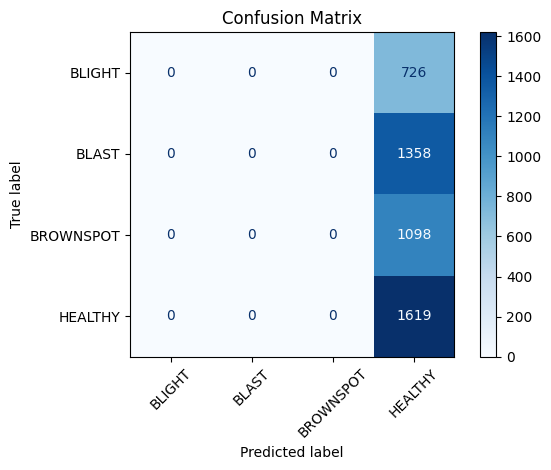

INFO:tensorflow:Assets written to: C:\Users\ADITYA DAS\Desktop\Machine Learning\CP_MODEL\EfficientNetB3_Phase1_CutMix_GridMask\assets


INFO:tensorflow:Assets written to: C:\Users\ADITYA DAS\Desktop\Machine Learning\CP_MODEL\EfficientNetB3_Phase1_CutMix_GridMask\assets


TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [33]:
# === Evaluate ===
y_true, y_pred = [], []
for images, labels in val_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=CLASSES))

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=CLASSES).plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# === Save ===
# Update save path to reflect EfficientNetB3 model
SAVE_PATH = r"C:\Users\ADITYA DAS\Desktop\Machine Learning\CP_MODEL\EfficientNetB3_Phase1_CutMix_GridMask"
model.save(SAVE_PATH)
print(f"✅ Model saved at: {SAVE_PATH}")
